In [1]:
import import_ipynb
import i_creation_environnement
import matplotlib.pyplot as plt

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
import h_plotting

matplotlib.style.use('ggplot')
import time

importing Jupyter notebook from i_creation_environnement.ipynb
importing Jupyter notebook from h_plotting.ipynb


In [2]:
env = i_creation_environnement.AugmentedGridworldEnv()

# SARSA

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [12]:
def SARSA(env, num_episodes, discount_factor=0.95, alpha=0.5, epsilon=0.1, display_trajectories = False):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = h_plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    states_trajectories = []
    reward_trajectories = []
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 2 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        if display_trajectories and i_episode%(num_episodes//10)==0:
            states_trajectories.append([])
            reward_trajectories.append([])
        
        # Reset the environment and pick the first action
        env.reset()
        state = 0
        action_probs = policy(state)
                        
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in itertools.count(): #generator of integer, continues until break 
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            
            # We avoid getting through the wall by setting the probability to 0
            for i in range(env.nA):
                if env.P[next_state][i][0][0] == 0.0:
                    next_action_probs[i] = 0
                    norm = np.linalg.norm(next_action_probs,ord=1)
                    next_action_probs = next_action_probs/norm
                
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            if display_trajectories and i_episode%(num_episodes//10)==0:
                states_trajectories[i_episode//(num_episodes//10)].append(state)
                reward_trajectories[i_episode//(num_episodes//10)].append(reward)
    
            if done:
                break
                
            action = next_action
            state = next_state   
            
        if display_trajectories and i_episode%(num_episodes//10)==0: #to display the trajectory
            print(env._ini_carrots==env._carrots)
            print("Episode length :", len(states_trajectories[i_episode//(num_episodes//10)]))
            env.render_trajectory(states_trajectories[i_episode//(num_episodes//10)], reward_trajectories[i_episode//(num_episodes//10)])
        
    return Q, stats

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True False  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True False  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]


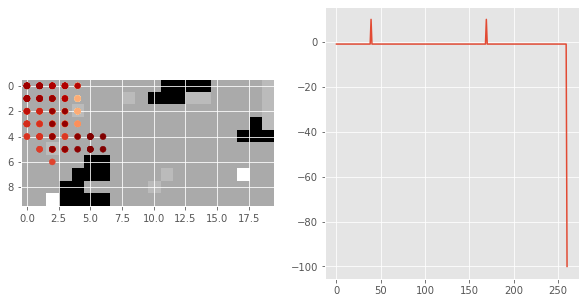

Episode 100/1000.[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  T

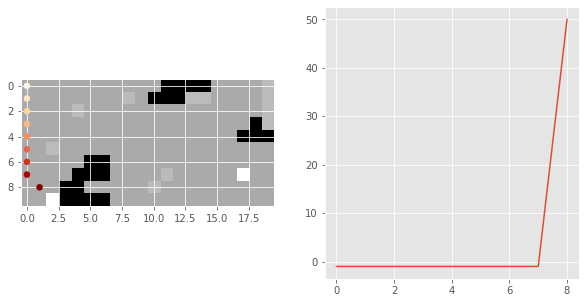

Episode 200/1000.[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True False  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True False  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True False  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  T

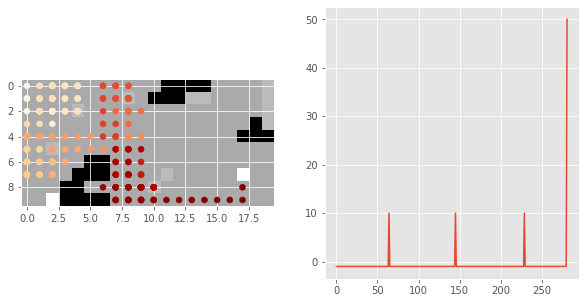

Episode 300/1000.[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True False  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True False  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  T

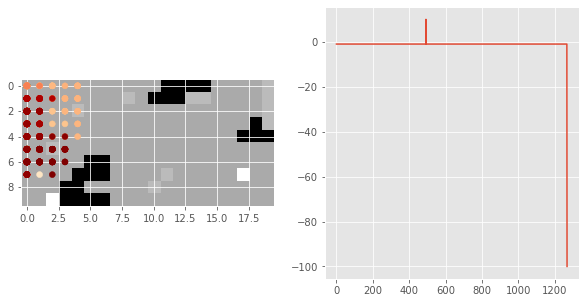

Episode 400/1000.[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True False  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  T

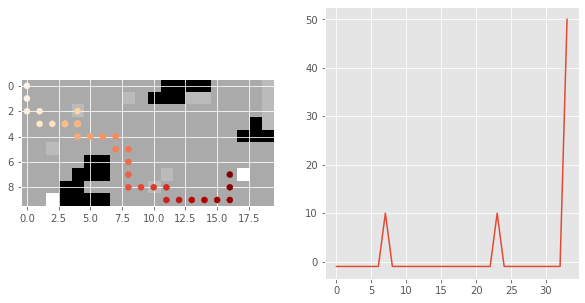

Episode 500/1000.[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  T

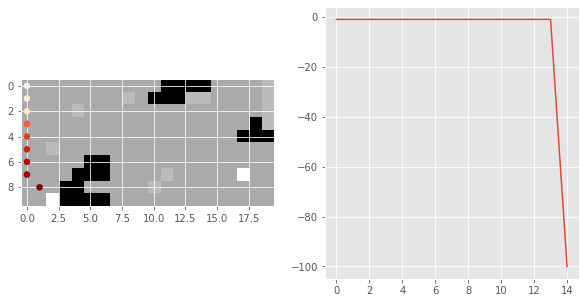

Episode 600/1000.[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True False  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True False  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  T

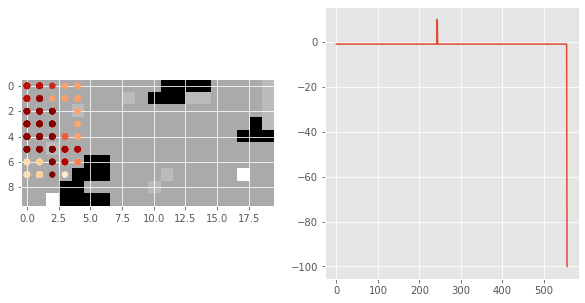

Episode 700/1000.[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  T

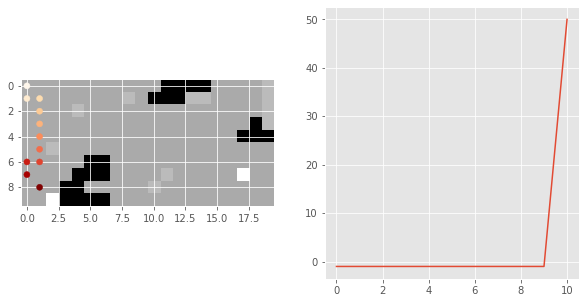

Episode 800/1000.[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  T

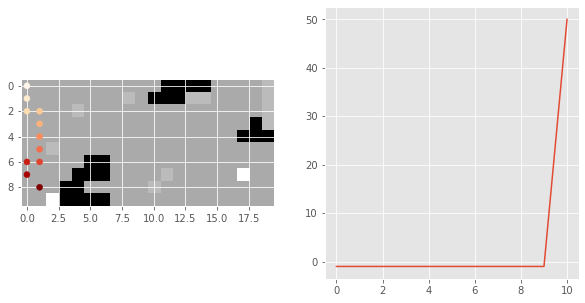

Episode 900/1000.[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  T

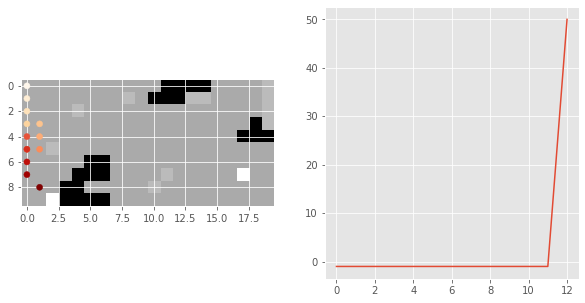

Episode 1000/1000.

In [14]:
t0 = time.time()
Q, stats = SARSA(env, num_episodes = 1000, display_trajectories=True)
t1 = time.time()

In [6]:
print("Running time : ", (t1-t0)/60, "minutes")

Running time :  0.35992244482040403 minutes


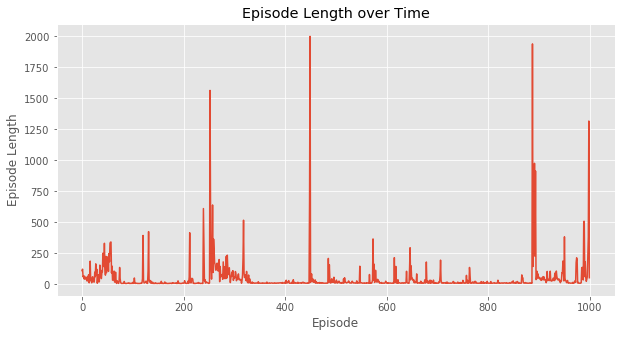

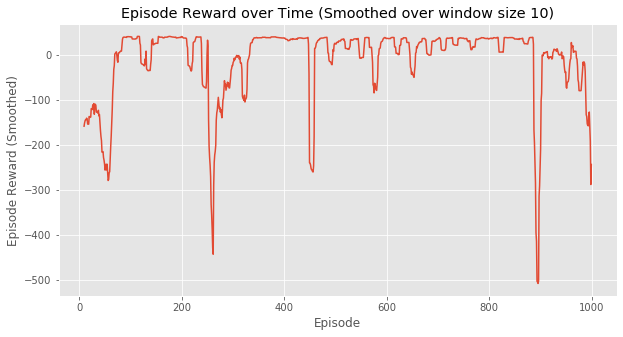

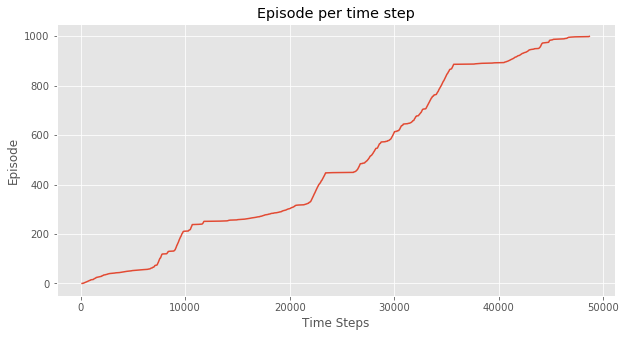

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [7]:
h_plotting.plot_episode_stats(stats)

# Q LEARNING

In [15]:
def Q_learning(env, num_episodes, discount_factor=0.99, alpha=0.5, epsilon=0.1, display_trajectories = False):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = h_plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    #Some exemples of trajectories
    states_trajectories = []
    reward_trajectories = []
    
    for i_episode in range(num_episodes):
        
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 2 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            #sys.stdout.flush()
        
        if display_trajectories and i_episode%(num_episodes//10)==0:
            states_trajectories.append([])
            reward_trajectories.append([])
        
        # Reset the environment and pick the first action
        env.reset()
        state = 0
        
        # One step in the environment
        for t in itertools.count():
            
            if np.unravel_index(state, env.shape) == (2,4):
                print(env._carrots[2,4])
        
            # Take a step
            action_probs = policy(state)
            
            # We avoid getting through the wall by setting the probability to 0
            for i in range(env.nA):
                if env.P[state][i][0][0] == 0.0:
                    action_probs[i] = 0
                    norm = np.linalg.norm(action_probs,ord=1)
                    action_probs = action_probs/norm
                    
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            if display_trajectories and i_episode%(num_episodes//10)==0:
                states_trajectories[i_episode//(num_episodes//10)].append(state)
                reward_trajectories[i_episode//(num_episodes//10)].append(reward)
                
            if done:
                break
                
            state = next_state
        
        if display_trajectories and i_episode%(num_episodes//10)==0: #to display the trajectory
            print(reward_trajectories[-1])
            print("Episode length :", len(states_trajectories[i_episode//(num_episodes//10)]))
            env.render_trajectory(states_trajectories[-1],reward_trajectories[-1])
    
    return Q, stats

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 10.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 10.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

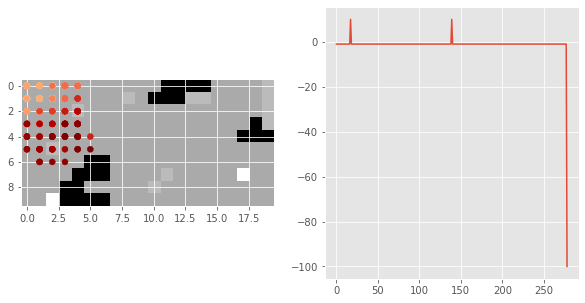

Episode 2/1000.False
False
False
False
Episode 4/1000.False
False
False
False
False
False
Episode 6/1000.False
False
False
False
False
False
False
Episode 8/1000.False
False
False
False
False
False
False
False
False
False
False
False
Episode 10/1000.False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Episode 12/1000.False
False
False
False
False
Episode 14/1000.False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Episode 16/1000.False
False
False
False
False
False
False
False
False
False
False
False
Episode 18/1000.False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Episode 20/1000.False
False
False
False
False
False
False
False
Episode 22/1000.False
Episode 24/1000.False
False
False
False
False
False
Episode 26/1000.False
False
False
False
Episode 28/1000.False
False
False
False
Episode 30/1000.False
False
False
False
False
Fa

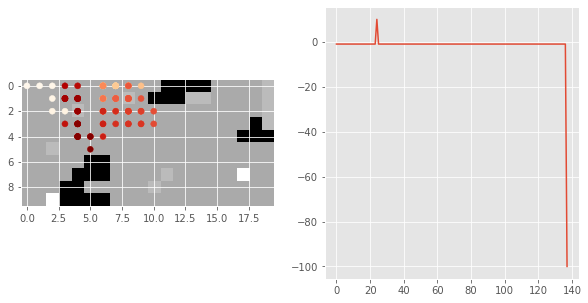

Episode 102/1000.False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Episode 104/1000.False
False
False
False
False
False
False
Episode 106/1000.False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Episode 108/1000.False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Episode 110/1000.False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Episode 112/1000.False
False
False
Fals

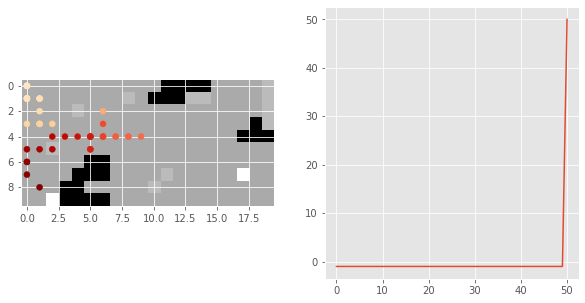

Episode 204/1000.False
Episode 206/1000.False
False
Episode 210/1000.False
False
False
Episode 224/1000.False
Episode 248/1000.False
False
False
Episode 260/1000.False
False
False
False
False
Episode 266/1000.False
False
False
False
False
False
Episode 274/1000.False
Episode 276/1000.False
False
Episode 286/1000.False
Episode 300/1000.[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -100.0]
Episode length : 26


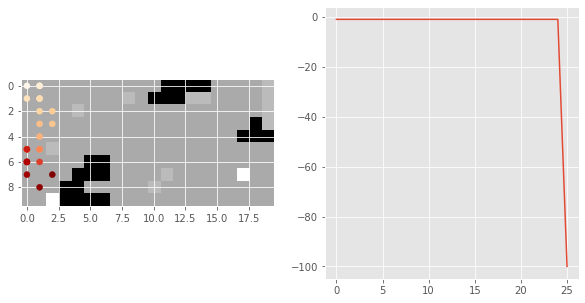

Episode 306/1000.False
Episode 310/1000.False
False
Episode 312/1000.False
False
Episode 314/1000.False
Episode 320/1000.False
False
False
False
Episode 324/1000.False
Episode 358/1000.False
Episode 400/1000.False
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -100.0]
Episode length : 13


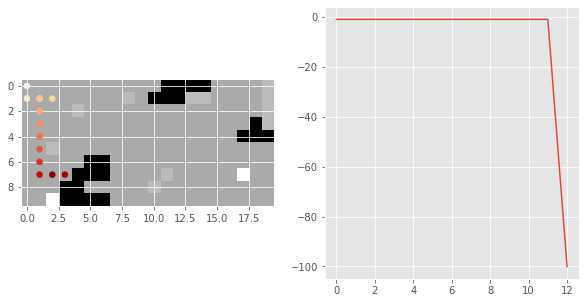

Episode 430/1000.False
False
False
False
False
Episode 444/1000.False
False
False
Episode 470/1000.False
False
False
False
Episode 484/1000.False
False
False
False
False
False
False
False
False
Episode 496/1000.False
False
False
False
False
False
False
Episode 500/1000.[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 50.0]
Episode length : 13


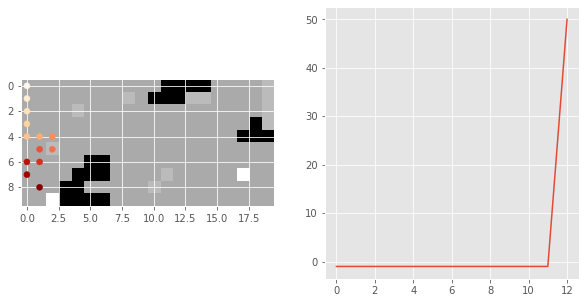

Episode 504/1000.False
False
False
Episode 512/1000.False
False
False
Episode 526/1000.False
Episode 530/1000.False
Episode 550/1000.False
False
Episode 594/1000.False
False
Episode 598/1000.False
False
False
Episode 600/1000.[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 50.0]
Episode length : 15


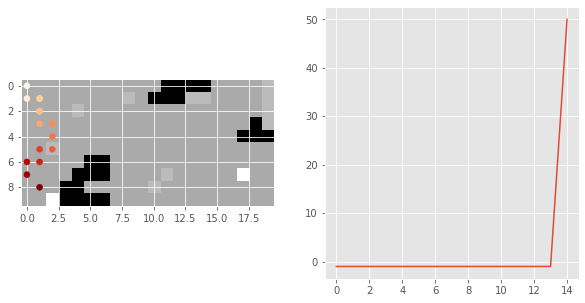

Episode 610/1000.False
False
False
False
Episode 622/1000.False
Episode 630/1000.False
False
False
False
False
False
Episode 636/1000.False
False
Episode 640/1000.False
False
False
False
Episode 650/1000.False
False
False
False
False
False
False
Episode 664/1000.False
False
False
False
False
False
False
False
False
False
Episode 680/1000.False
False
False
False
Episode 694/1000.False
Episode 696/1000.False
False
False
Episode 700/1000.[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 50.0]
Episode length : 11


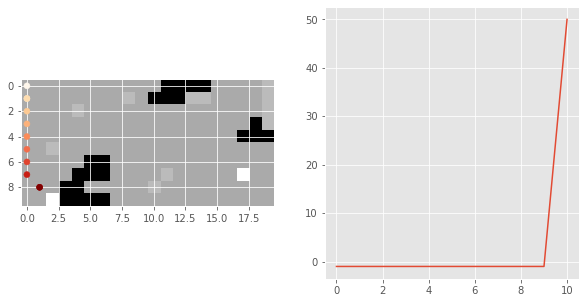

Episode 702/1000.False
False
False
False
False
Episode 710/1000.False
False
False
Episode 712/1000.False
False
False
False
False
Episode 736/1000.False
Episode 778/1000.False
Episode 800/1000.[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 50.0]
Episode length : 14


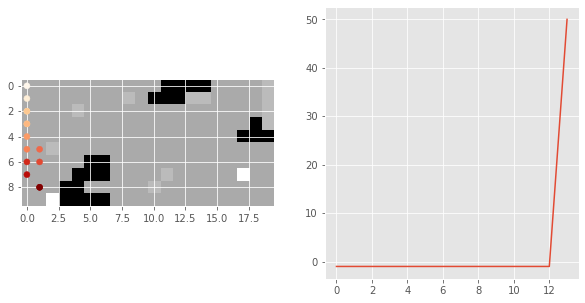

Episode 804/1000.False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Episode 806/1000.False
False
Episode 830/1000.False
False
False
False
Episode 832/1000.False
Episode 852/1000.False
Episode 860/1000.False
False
False
False
False
False
False
False
False
Episode 864/1000.False
False
False
Episode 866/1000.False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Episode 900/1000.[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 50.0]
Episode length : 13


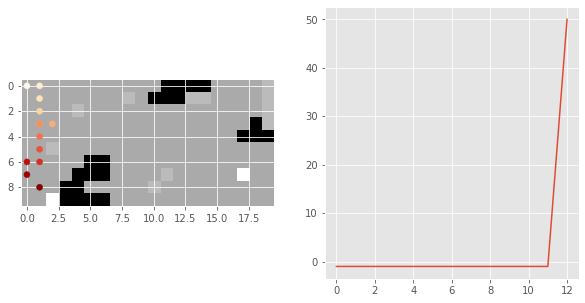

Episode 908/1000.False
Episode 926/1000.False
False
Episode 932/1000.False
False
Episode 982/1000.False
False
False
False
Episode 990/1000.False
Episode 1000/1000.

In [16]:
t0 = time.time()
Q, stats = Q_learning(env, 1000, epsilon = 0.5, display_trajectories=True)
t1 = time.time()

In [10]:
print("Running time : ", (t1-t0)/60, "minutes")

Running time :  0.3620597362518311 minutes


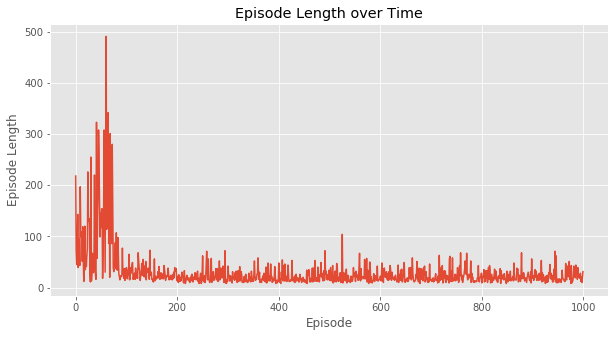

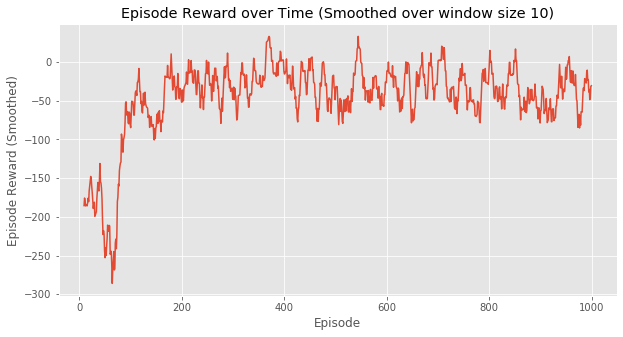

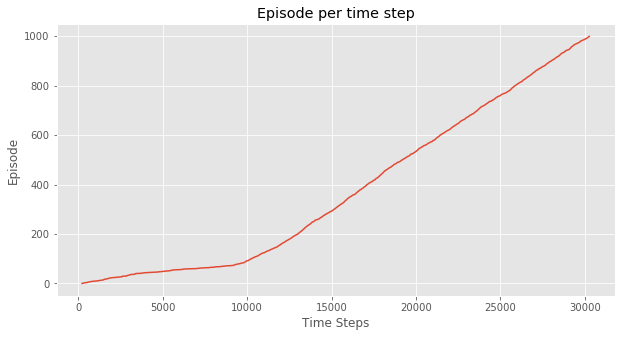

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
h_plotting.plot_episode_stats(stats)